In [9]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv

load_dotenv()

True

In [10]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from lib.bert import get_cls_embedding
from lib.examples import examples_df


X = []
y = []

for _, row in tqdm(examples_df.iterrows(), total=len(examples_df), desc="Encoding examples"):
    emb = get_cls_embedding(row["concept1"], row["concept2"])
    X.append(emb)
    y.append(row["relation"])

X = np.array(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Encoding examples: 100%|██████████| 3600/3600 [02:55<00:00, 20.56it/s]


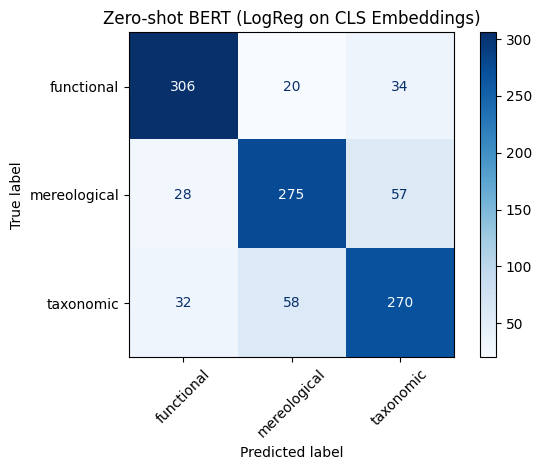

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Zero-shot BERT (LogReg on CLS Embeddings)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Cohen's Kappa Score: 0.6819
Classification Report:

              precision    recall  f1-score   support

  functional       0.84      0.85      0.84       360
mereological       0.78      0.76      0.77       360
   taxonomic       0.75      0.75      0.75       360

    accuracy                           0.79      1080
   macro avg       0.79      0.79      0.79      1080
weighted avg       0.79      0.79      0.79      1080



/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


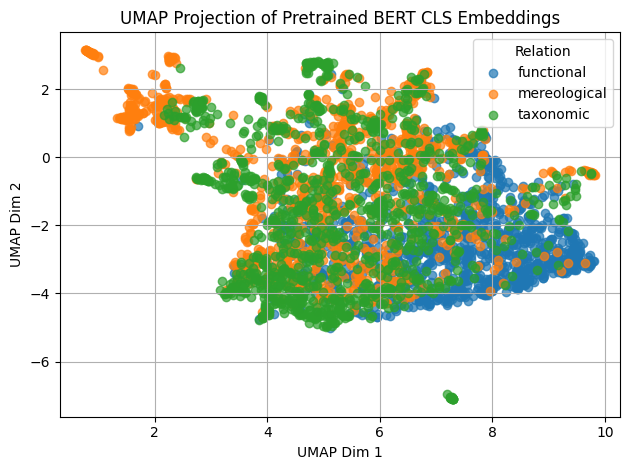

In [12]:
import umap
import matplotlib.pyplot as plt

# Create a UMAP object
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Use the same label encoder from before
relation_names = label_encoder.inverse_transform(sorted(set(y_encoded)))
colors = ["blue", "orange", "green"]  # Adjust if you have more classes

for i, rel in enumerate(relation_names):
    idx = y_encoded == label_encoder.transform([rel])[0]
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=rel, alpha=0.7)

plt.title("UMAP Projection of Pretrained BERT CLS Embeddings")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Relation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, y_encoded, metric='cosine')

print("Silhouette score:", score)

Silhouette score: 0.023731945


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.stats import spearmanr

similarity_matrix = cosine_similarity(X)

N = len(y)
ground_truth_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if y[i] == y[j]:
            ground_truth_matrix[i, j] = 1


# Flatten upper triangle of both matrices (to avoid self-similarity)
def flatten_upper_tri(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

sim_flat = flatten_upper_tri(similarity_matrix)
gt_flat = flatten_upper_tri(ground_truth_matrix)

rsa_score, pvalue = spearmanr(sim_flat, gt_flat)
print("RSA score (Spearman correlation):", rsa_score)
print("P-value:", pvalue)

RSA score (Spearman correlation): 0.03976739158081186
P-value: 0.0
